<h1 align='center'><b><font color='indianred'></p>Spam Detection HW</b></h1>

<font color = 'indianred' size = 4 >**Read complete instructions before starting the HW** </font>


# <font color='indianred'> **Q1: Load the dataset  (1 Point)**

- For this Hw you will usespam dataset from kaggle which can be found from [this](https://www.kaggle.com/uciml/sms-spam-collection-dataset) link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe. 

- There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

- Rename columns as label and message

- Find the %  ham amd spam in the data.





## Import Libraries

In [2]:
import os
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install -U nltk -qq
  !pip install -U spacy -qq
  !python -m spacy download en_core_web_sm -qq

  # basepath  = '/content/drive/MyDrive/data'
  sys.path.append('/content/drive/MyDrive/NLP_UTD/custom-functions')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-web-sm 3.4.1 requires spacy<3.5.0,>=3.4.0, but you have spacy 3.5.0 which is incompatible.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-26 23:18:35.442891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-26 23:18:36.802088: W tensorflow/compiler/xla/str

In [3]:
# Import the joblib library for saving and loading models
import joblib

# Import scikit-learn classes for building models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Import the scipy library for working with sparse matrices
from scipy.sparse import csr_matrix

from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import custom_preprocessor_mod as cp
from  featurizer import ManualFeatures
from  plot_learning_curve import plot_learning_curve

In [4]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python38.zip',
 '/usr/lib/python3.8',
 '/usr/lib/python3.8/lib-dynload',
 '',
 '/usr/local/lib/python3.8/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.8/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/NLP_UTD/custom-functions']

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
# !pip install kaggle

In [7]:
# drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = ('/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/.kaggle')
os.chdir('/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3')

In [8]:
# !mkdir ~/.kaggle
# !mv .kaggle /root/
# !touch ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json

In [9]:
base_folder = Path('/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3')
data_folder = base_folder 
model_folder = base_folder
archive_folder = base_folder
kaggle_api = base_folder

In [10]:
# ! kaggle datasets download -d uciml/sms-spam-collection-dataset -p {archive_folder}

In [11]:
# !ls /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/kaggle

In [12]:
# !ls {archive_folder}

In [13]:
# data_file = archive_folder/'sms-spam-collection-dataset.zip'

In [14]:
# !unzip -q {data_file} -d {data_folder}

In [15]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [16]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [17]:
df = df.drop(columns=[ 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df = df.rename(columns={'v1': 'label', 'v2': 'text_of_email'})
df.head()

,label,text_of_email
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
df.groupby('label').describe()

text_of_email                                                            \
              count unique                                                top   
label                                                                           
ham            4825   4516                             Sorry, I'll call later   
spam            747    653  Please call our customer service representativ...   

            
      freq  
label       
ham     30  
spam     4

In [19]:
df['label_num'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,text_of_email,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [20]:
counts = df['label'].value_counts()
percentages = counts / len(df) * 100
print(percentages)

ham     86.593683
spam    13.406317
Name: label, dtype: float64


# <font color='indianred'> **Q2 : Provide the metric for evaluating model (1 Point)**</font>

As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

F1 score - This is the harmonic mean of precision and recall thus giving equal weights to both. These are sensitive to the minority class. In a binary classification problem with imbalanced classes, a high F1 score indicates that the model is able to correctly identify instances of the minority class while keeping false positives to a minimum.

# <font color='indianred'> **Q3 : Classification Pipelines (18 Points)**</font>

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use folllowing methods to create fearures which you can use in your model. 

    1. Sparse Embeddings (TF-IDF) (6 Points)
    2. Feature Engineering (see examples below) (6 Points)
    3. Sparse Embeddings (TF-IDF) + Feature Engineering (6 Points)

**Approach:**

<font color='indianred'> ****Use a smaller subset of dataset (e.g. 10 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on randomly selected larger subset (e.g. 40%) of the data.** </font>

**Requirements:** 

1. You can use any ML model (Logistic Regression, XgBoost) for the classification. You will need to tune the **model for imbalanced dataset** (The link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Words, characters, digits, exclamation marks, numbers, Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/). 

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.). 

4. Think carefully about the pre-processing you will do.

Tip: <font color = 'indianred'>**Using GridSearch for hyperparameter tuning might take a lot of time. Try using RandomizedSearch.**</font> You can also explore faster implementation of Gridsearch and RandomizedSearch in sklearn: 

1. [Halving Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html?highlight=halving#sklearn.model_selection.HalvingGridSearchCV)

2. [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html?highlight=halving#sklearn.model_selection.HalvingRandomSearchCV)





In [21]:
df.head()

,label,text_of_email,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


##Creating subset of data & Splitting data

In [ ]:
df_smaller = df.sample(frac = 0.3, replace = True, random_state = 1)
counts = df_smaller['label'].value_counts()
percentages = counts / len(df_smaller) * 100
print(percentages)

ham     87.858852
spam    12.141148
Name: label, dtype: float64


In [ ]:
x = df_smaller['text_of_email'].values
y = df_smaller['label_num'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42, stratify = y)
print(f'x_train: {x_train.shape}, y_train:  {y_train.shape}')
print(f'x_test: {x_test.shape}, y_test:  {y_test.shape}')

x_train: (1337,), y_train:  (1337,)
x_test: (335,), y_test:  (335,)


In [ ]:
x_train

array(['I am in your office na.', "Honey boo I'm missing u.",
       "Wa, ur openin sentence very formal... Anyway, i'm fine too, juz tt i'm eatin too much n puttin on weight...Haha... So anythin special happened?",
       ...,
       'Think i might have to give it a miss. Am teaching til twelve, then have lecture at two. Damn this working thing.',
       "Joy's father is John. Then John is the NAME of Joy's father. Mandan",
       'Dear are you angry i was busy dear'], dtype=object)

In [ ]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# cp.SpacyPreprocessor?

In [ ]:
x_train_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(x_train)
file_x_train_cleaned_sparse_embed = data_folder / 'x_train_cleaned_sparse_embed.pkl'
joblib.dump(x_train_cleaned, file_x_train_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/x_train_cleaned_sparse_embed.pkl']

In [ ]:
x_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(x_test)
file_x_test_cleaned_sparse_embed = data_folder / 'x_test_cleaned_sparse_embed.pkl'
joblib.dump(x_test_cleaned, file_x_test_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/x_test_cleaned_sparse_embed.pkl']

##Sparse Embeddings (TF-IDF)

###Pipeline - GridSearch

In [ ]:
# Create Pipeline
classifier_1 = Pipeline([
    ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
    ('classifier', xgb.XGBClassifier(scale_pos_weight = 9, max_depth = 5, n_estimators = 100, random_state = 42))
    ])

# Param Grid
param_grid_classifier_1 = {'vectorizer__max_features': [100, 500, 1000],
                            'classifier__max_depth': [3, 5, 7, 9],
                            # 'classifier__min_child_weight': [1, 3, 5],
                            # 'classifier__gamma': [0, 0.1, 0.2, 0.3],
                            'classifier__subsample': [0.6, 0.8, 1.0],
                            # 'classifier__colsample_bytree': [0.6, 0.8, 1.0],
                            # 'classifier__scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000],
                            'classifier__learning_rate': [0.05, 0.1],
                            'classifier__n_estimators': [50, 100, 200, 300]
                           }

# GridSearch
grid_classifier_1 = GridSearchCV(estimator = classifier_1, param_grid = param_grid_classifier_1, cv = 3)

###Fit data

In [ ]:
# Fit the model on training data
x_train_cleaned_sparse_embed = joblib.load(file_x_train_cleaned_sparse_embed)
grid_classifier_1.fit(x_train_cleaned_sparse_embed, y_train)

print(f'Best cross-validation score: {grid_classifier_1.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.96

Best parameters:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 0.6, 'vectorizer__max_features': 500}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=500, token_pattern='[\\S]+')),
                ('classifier',
                 XGBClassifier(max_depth=7, n_estimators=300, random_state=42,
                               scale_pos_weight=9, subsample=0.6))])


In [ ]:
file_best_estimator_pipeline1_round1 = model_folder / 'pipeline1_round1_best_estimator.pkl'
file_complete_grid_pipeline1_round1 = model_folder / 'pipeline1_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_1.best_estimator_, file_best_estimator_pipeline1_round1)
joblib.dump(grid_classifier_1, file_complete_grid_pipeline1_round1)

['/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/pipeline1_round1_complete_grid.pkl']

In [ ]:
# load the saved model
best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
complete_grid_pipeline1_round1 = joblib.load(file_complete_grid_pipeline1_round1)

### Plotting Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

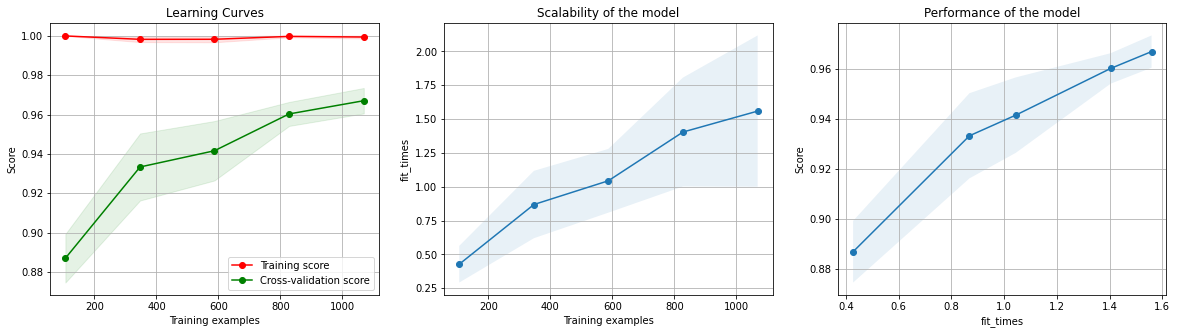

In [ ]:
plot_learning_curve(best_estimator_pipeline1_round1, 'Learning Curves',
                    x_train_cleaned_sparse_embed, y_train, n_jobs=-1)

###Cross Validation and Train scores

In [ ]:
# let's check the train scores
print('Train score: ', round(best_estimator_pipeline1_round1.score(x_train_cleaned_sparse_embed, y_train),4))

# let's check the cross validation score
print('Cross Validation score: ', round(complete_grid_pipeline1_round1.best_score_, 4))

Train score:  0.9993
Cross Validation score:  0.9626


###Evaluating model on test set

In [ ]:
# Final Pipeline
def final_pipeline_1(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_x_test_cleaned_sparse_embed)
    best_estimator_pipeline1_round1 = joblib.load(file_best_estimator_pipeline1_round1)
    predictions = best_estimator_pipeline1_round1.predict(cleaned_text)
    return predictions
y_test_pred_1 = final_pipeline_1(x_test)

print('\nTest set classification report in step 1:\n\n', 
      classification_report(y_test, y_test_pred_1))


Test set classification report in step 1:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       294
           1       0.95      0.88      0.91        41

    accuracy                           0.98       335
   macro avg       0.97      0.94      0.95       335
weighted avg       0.98      0.98      0.98       335



##Feature Engineering - Manual Features

In [ ]:
# ManualFeatures?

In [27]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm')

In [ ]:
x_train_features, feature_names = featurizer.fit_transform(x_train)
print(x_train_features[0:3])

print('Feature names\n')
feature_names

[[  6.          22.          17.           2.42857143   0.
    0.           0.           2.           1.           0.
    0.        ]
 [  6.          25.          20.           2.85714286   0.
    0.           0.           3.           2.           1.
    0.        ]
 [ 27.         133.         107.           3.82142857   0.
    0.           2.           8.           0.           6.
    5.        ]]
Feature names



['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner']

###Pipeline - GridSearch

In [ ]:
# Create Pipeline
classifier_2 = Pipeline([
    ('classifier', xgb.XGBClassifier(scale_pos_weight = 9, max_depth = 5, n_estimators = 100, random_state = 42))
                        ])

# Param Grid
param_grid_classifier_2 = {'classifier__max_depth': [3, 5, 7, 9],
                            # 'classifier__min_child_weight': [1, 3, 5],
                            # 'classifier__gamma': [0, 0.1, 0.2, 0.3],
                            'classifier__subsample': [0.6, 0.8, 1.0],
                            # 'classifier__colsample_bytree': [0.6, 0.8, 1.0],
                            # 'classifier__scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000],
                            'classifier__learning_rate': [0.01, 0.05, 0.1],
                            'classifier__n_estimators': [50, 100, 200, 300]
}
                          
                           
# GridSearch
grid_classifier_2 = GridSearchCV(estimator=classifier_2, param_grid=param_grid_classifier_2, cv=3)

###Fit data

In [ ]:
# Fit the model on training data
grid_classifier_2.fit(x_train_features, y_train)

print(f'Best cross-validation score: {grid_classifier_2.best_score_:.2f}')
print("\nBest parameters: ", grid_classifier_2.best_params_)
print("\nBest estimator: ", grid_classifier_2.best_estimator_)

Best cross-validation score: 0.98

Best parameters:  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}

Best estimator:  Pipeline(steps=[('classifier',
                 XGBClassifier(learning_rate=0.05, max_depth=7,
                               n_estimators=300, random_state=42,
                               scale_pos_weight=9, subsample=0.8))])


In [ ]:
file_best_estimator_pipeline2_round1 = model_folder / 'pipeline2_round1_best_estimator.pkl'
file_complete_grid_pipeline2_round1 = model_folder / 'pipeline2_round1_complete_grid.pkl'

In [ ]:
joblib.dump(grid_classifier_2.best_estimator_, file_best_estimator_pipeline2_round1)
joblib.dump(grid_classifier_2, file_complete_grid_pipeline2_round1)

['/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/pipeline2_round1_complete_grid.pkl']

In [ ]:
# load the saved model
best_estimator_pipeline2_round1 = joblib.load(file_best_estimator_pipeline2_round1)
complete_grid_pipeline2_round1 = joblib.load(file_complete_grid_pipeline2_round1)

### Plotting Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

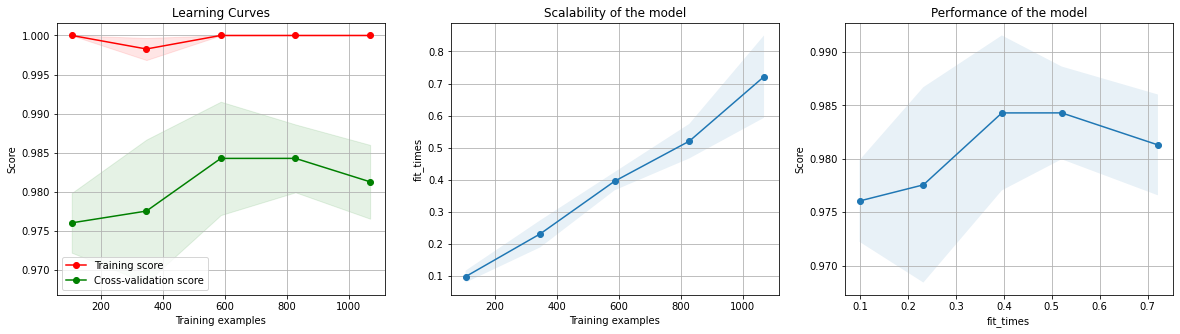

In [ ]:
plot_learning_curve(best_estimator_pipeline2_round1, 'Learning Curves',
                    x_train_features, y_train, n_jobs=-1)

###Cross Validation and Train scores

In [ ]:
# let's check the train scores
print('Train score: ', round(best_estimator_pipeline2_round1.score(x_train_features, y_train), 4))

# let's check the cross validation score
print('Cross Validation score: ', round(complete_grid_pipeline2_round1.best_score_, 4))

Train score:  1.0
Cross Validation score:  0.9843


###Evaluating model on test set

In [ ]:
# Final Pipeline
def final_pipeline_2(text):
    features, feature_names = featurizer.fit_transform(text)
    best_estimator_pipeline2_round1 = joblib.load(file_best_estimator_pipeline2_round1)
    predictions = best_estimator_pipeline2_round1.predict(features)
    return predictions
y_test_pred_2 = final_pipeline_2(x_test)

print('\nTest set classification report in step 2:\n\n', 
      classification_report(y_test, y_test_pred_2))


Test set classification report in step 2:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       294
           1       0.95      0.88      0.91        41

    accuracy                           0.98       335
   macro avg       0.97      0.94      0.95       335
weighted avg       0.98      0.98      0.98       335



##Sparse Embeddings (TF-IDF) + Feature Engineering

In [ ]:
x_train_cleaned_sparse_embed = joblib.load(file_x_train_cleaned_sparse_embed)

In [ ]:
x_train_final = pd.concat((pd.DataFrame(x_train_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(x_train_features, columns=feature_names)), axis =1)
x_train_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,office na,6.0,22.0,17.0,2.428571,0.0,0.0,0.0,2.0,1.0,0.0,0.0
1,honey boo miss u.,6.0,25.0,20.0,2.857143,0.0,0.0,0.0,3.0,2.0,1.0,0.0
2,wa ur openin sentence formal fine juz tt eatin...,27.0,133.0,107.0,3.821429,0.0,0.0,2.0,8.0,0.0,6.0,5.0
3,say quit least5times day wudn't notice nah m...,43.0,197.0,153.0,3.477273,1.0,1.0,2.0,6.0,5.0,10.0,1.0
4,seriously spell,8.0,40.0,33.0,3.666667,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
x_train_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               1337 non-null   object 
 1   count_words                1337 non-null   float64
 2   count_characters           1337 non-null   float64
 3   count_characters_no_space  1337 non-null   float64
 4   avg_word_length            1337 non-null   float64
 5   count_digits               1337 non-null   float64
 6   count_numbers              1337 non-null   float64
 7   noun_count                 1337 non-null   float64
 8   aux_count                  1337 non-null   float64
 9   verb_count                 1337 non-null   float64
 10  adj_count                  1337 non-null   float64
 11  ner                        1337 non-null   float64
dtypes: float64(11), object(1)
memory usage: 125.5+ KB


In [ ]:
subset = x_train_final[0:30]
subset.shape

(30, 12)

In [32]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [ ]:
sparse_features = Pipeline([('sparse', SparseTransformer()), ])
vectorizer = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])
sparse_features.fit_transform(subset.iloc[:, 1:])
vectorizer.fit_transform(subset.iloc[:, 0])

<30x5 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [ ]:
combined_features = ColumnTransformer(
 transformers=[
     ('tfidf', vectorizer, 'cleaned_text'),
      ], remainder=sparse_features
     )
test = combined_features.fit_transform(subset)

###Pipeline - GridSearch

In [ ]:
# Create Pipeline
classifier_3 = Pipeline([('combined_features',  combined_features),
                         ('classifier', xgb.XGBClassifier(scale_pos_weight = 9, max_depth = 5, n_estimators = 100, random_state = 42))
                        ])
classifier_3.get_params().keys()

# Param Grid
param_grid_classifier_3 = {'combined_features__tfidf__tfidf__max_features': [500, 1000, 2000], 
                           'classifier__max_depth': [3, 5, 7, 9],
                            # 'classifier__min_child_weight': [1, 3, 5],
                            # 'classifier__gamma': [0, 0.1, 0.2, 0.3],
                            'classifier__subsample': [0.6, 0.8, 1.0],
                            # 'classifier__colsample_bytree': [0.6, 0.8, 1.0],
                            # 'classifier__scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000],
                            'classifier__learning_rate': [0.01, 0.05, 0.1],
                            'classifier__n_estimators': [50, 100, 200, 300]
                          }

# GridSearch
grid_classifier_3 = GridSearchCV(estimator=classifier_3, param_grid=param_grid_classifier_3, cv=3)

###Fit data

In [ ]:
# Fit Data
grid_classifier_3.fit(x_train_final, y_train)

# Best params
print("Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.99

Best parameters:  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 0.6, 'combined_features__tfidf__tfidf__max_features': 2000}

Best estimator:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=2000))]),
                                                  'cleaned_text')])),
                ('classifier',
                 XGBClassifier(learning_rate=0.05, max_depth=5,
                               n_estimators=200, random_state=42,
                               scale_pos_weight=9, subsample=0.6))])


In [ ]:
# Saving the model
file_best_estimator_pipeline3_round1 = model_folder / 'pipeline3_round1_best_estimator.pkl'
file_complete_grid_pipeline3_round1 = model_folder / 'pipeline3_round1_complete_grid.pkl'

joblib.dump(grid_classifier_3.best_estimator_, file_best_estimator_pipeline3_round1)
joblib.dump(grid_classifier_3, file_complete_grid_pipeline3_round1)

# Loading the saved model
best_estimator_pipeline3_round1 = joblib.load(file_best_estimator_pipeline3_round1)
complete_grid_pipeline3_round1 = joblib.load(file_complete_grid_pipeline3_round1)

### Plotting Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

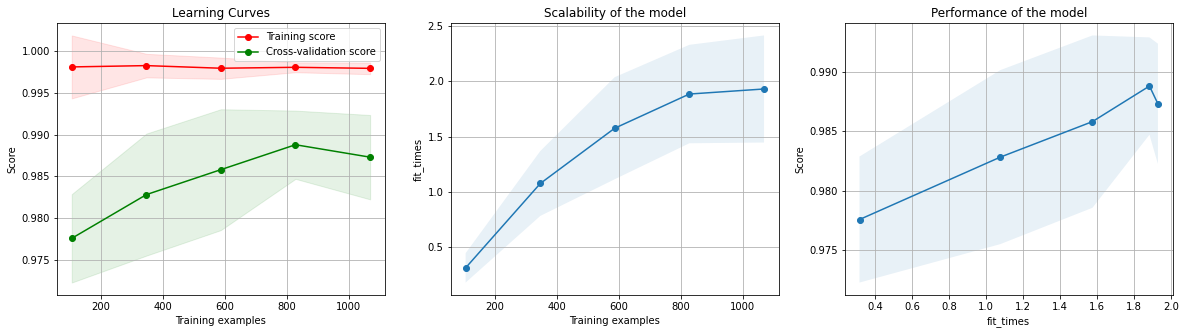

In [ ]:
# Plotting Learning Curve
plot_learning_curve(best_estimator_pipeline3_round1, 'Learning Curves',
                    x_train_final, y_train, n_jobs=-1)

###Cross Validation and Train scores

In [ ]:
# Cross Validation score & Train score
print('Train score: ', round(best_estimator_pipeline3_round1.score(x_train_final, y_train), 4))

print('Cross Validation score: ', round(complete_grid_pipeline3_round1.best_score_, 4))

Train score:  0.9985
Cross Validation score:  0.9873


### Evaluating model on test set

In [ ]:
# Final Pipeline
def final_pipeline_3(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text = joblib.load(file_x_test_cleaned_sparse_embed)
    X_features, feature_names = featurizer.fit_transform(text)
    X_final = pd.concat((pd.DataFrame(cleaned_text, columns=['cleaned_text']),
                         pd.DataFrame(X_features, columns=feature_names)), axis=1)
    best_estimator_pipeline3_round1 = joblib.load(file_best_estimator_pipeline3_round1)
    predictions = best_estimator_pipeline3_round1.predict(X_final)
    return predictions
y_test_pred_3 = final_pipeline_3(x_test)
print('\nTest set classification report in step 3:\n\n', classification_report(y_test, y_test_pred_3 ))


Test set classification report in step 3:

               precision    recall  f1-score   support

           0       0.98      0.99      0.99       294
           1       0.95      0.88      0.91        41

    accuracy                           0.98       335
   macro avg       0.97      0.94      0.95       335
weighted avg       0.98      0.98      0.98       335



##Complete Dataset

In [22]:
x_full = df['text_of_email'].values
y_full = df['label_num'].values
x_train_full, x_test_full, y_train_full, y_test_full = train_test_split(x_full, y_full, test_size = 0.2, random_state = 42, stratify = y_full)
print(f'x_train_full: {x_train_full.shape}, y_train_full:  {y_train_full.shape}')
print(f'x_test_full: {x_test_full.shape}, y_test_full:  {y_test_full.shape}')

x_train_full: (4457,), y_train_full:  (4457,)
x_test_full: (1115,), y_test_full:  (1115,)


In [23]:
x_train_full_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(x_train_full)
file_x_train_full_cleaned_sparse_embed = data_folder / 'x_train_full_cleaned_sparse_embed.pkl'
joblib.dump(x_train_full_cleaned, file_x_train_full_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/x_train_full_cleaned_sparse_embed.pkl']

In [24]:
x_test_full_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(x_test_full)
file_x_test_full_cleaned_sparse_embed = data_folder / 'x_test_full_cleaned_sparse_embed.pkl'
joblib.dump(x_test_full_cleaned, file_x_test_full_cleaned_sparse_embed)

['/content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/x_test_full_cleaned_sparse_embed.pkl']

In [25]:
x_train_full_cleaned_sparse_embed = joblib.load(file_x_train_full_cleaned_sparse_embed)

In [28]:
featurizer = ManualFeatures(spacy_model='en_core_web_sm')

In [29]:
x_train_full_features, feature_names_full = featurizer.fit_transform(x_train_full)
print(x_train_full_features[0:3])

print('Feature names on complete dataset\n')
feature_names_full

[[ 3.         16.         14.          3.5         0.          0.
   0.          0.          0.          1.          0.        ]
 [ 9.         30.         22.          2.2         0.          0.
   0.          2.          1.          1.          0.        ]
 [10.         33.         24.          2.18181818  1.          1.
   1.          6.          0.          0.          0.        ]]
Feature names on complete dataset



['count_words',
 'count_characters',
 'count_characters_no_space',
 'avg_word_length',
 'count_digits',
 'count_numbers',
 'noun_count',
 'aux_count',
 'verb_count',
 'adj_count',
 'ner']

In [31]:
x_train_full_final = pd.concat((pd.DataFrame(x_train_full_cleaned_sparse_embed, columns=['cleaned_text']),
                           pd.DataFrame(x_train_full_features, columns = feature_names_full)), axis =1)
x_train_full_final.head()

,cleaned_text,count_words,count_characters,count_characters_no_space,avg_word_length,count_digits,count_numbers,noun_count,aux_count,verb_count,adj_count,ner
0,go,3.0,16.0,14.0,3.500000,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,will not wat wit guy,9.0,30.0,22.0,2.200000,0.0,0.0,0.0,2.0,1.0,1.0,0.0
2,ok k sry knw 2 siva tat y askd,10.0,33.0,24.0,2.181818,1.0,1.0,1.0,6.0,0.0,0.0,0.0
3,stand away heart ache wonder crave,34.0,145.0,112.0,3.200000,0.0,0.0,0.0,2.0,7.0,4.0,0.0
4,finish work,8.0,43.0,36.0,4.000000,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [32]:
x_train_full_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4457 entries, 0 to 4456
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaned_text               4457 non-null   object 
 1   count_words                4457 non-null   float64
 2   count_characters           4457 non-null   float64
 3   count_characters_no_space  4457 non-null   float64
 4   avg_word_length            4457 non-null   float64
 5   count_digits               4457 non-null   float64
 6   count_numbers              4457 non-null   float64
 7   noun_count                 4457 non-null   float64
 8   aux_count                  4457 non-null   float64
 9   verb_count                 4457 non-null   float64
 10  adj_count                  4457 non-null   float64
 11  ner                        4457 non-null   float64
dtypes: float64(11), object(1)
memory usage: 418.0+ KB


In [33]:
subset_full = x_train_full_final[0:30]
subset_full.shape

(30, 12)

In [35]:
class SparseTransformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return csr_matrix(X)

In [36]:
sparse_features_full = Pipeline([('sparse', SparseTransformer()), ])
vectorizer_full = Pipeline([('tfidf', TfidfVectorizer(max_features=5)), ])
sparse_features_full.fit_transform(subset_full.iloc[:, 1:])
vectorizer_full.fit_transform(subset_full.iloc[:, 0])

<30x5 sparse matrix of type '<class 'numpy.float64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [37]:
combined_features_full = ColumnTransformer(
 transformers = [
     ('tfidf', vectorizer_full, 'cleaned_text'),
      ], remainder =sparse_features_full
     )
test_full = combined_features_full.fit_transform(subset_full)

###Pipeline - GridSearch

In [57]:
# Create Pipeline
classifier_full = Pipeline([
    ('combined_features',  combined_features_full),
    ('classifier', xgb.XGBClassifier(scale_pos_weight = 9, learning_rate = 0.05, max_depth = 5, n_estimators = 200, sub_sample = 0.6, random_state = 42)),
                        ])

# Param Grid
param_grid_classifier_full = {'combined_features__tfidf__tfidf__max_features': [1000, 2000, 3000], 
                            'classifier__max_depth': [5, 7, 9],
                            # 'classifier__min_child_weight': [1, 3, 5],
                            # 'classifier__gamma': [0, 0.1, 0.2, 0.3],
                            'classifier__subsample': [0.6, 0.8],
                            # 'classifier__colsample_bytree': [0.6, 0.8, 1.0],
                            'classifier__scale_pos_weight': [8.5, 9, 9.5, 10],
                            'classifier__learning_rate': [0.05, 0.1],
                            'classifier__n_estimators': [100, 200, 300]
}
                          
                           
# GridSearch
grid_classifier_full = GridSearchCV(estimator = classifier_full, param_grid = param_grid_classifier_full, cv = 3)

###Fit data

In [58]:
# Fit Data
grid_classifier_full.fit(x_train_full_final, y_train_full)

Best cross-validation score on complete dataset: 0.98

Best parameters on complete dataset:  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 9, 'classifier__subsample': 0.8, 'combined_features__tfidf__tfidf__max_features': 3000}

Best estimator on complete dataset:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=3000))]),
                                                  'cleaned_text')])),
                ('classifier',
                 XGBClassifier(learning_rate=0.05, max_depth=7,
                               n_estimators=300, r

In [59]:
# Best params
print("Best cross-validation score on complete dataset: {:.2f}".format(grid_classifier_full.best_score_))
print("\nBest parameters on complete dataset: ", grid_classifier_full.best_params_)
print("\nBest estimator on complete dataset: ", grid_classifier_full.best_estimator_)

Best cross-validation score on complete dataset: 0.98

Best parameters on complete dataset:  {'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 9, 'classifier__subsample': 0.8, 'combined_features__tfidf__tfidf__max_features': 3000}

Best estimator on complete dataset:  Pipeline(steps=[('combined_features',
                 ColumnTransformer(remainder=Pipeline(steps=[('sparse',
                                                              SparseTransformer())]),
                                   transformers=[('tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=3000))]),
                                                  'cleaned_text')])),
                ('classifier',
                 XGBClassifier(learning_rate=0.05, max_depth=7,
                               n_estimators=300, r

In [60]:
# Saving the model
file_best_estimator_pipeline_full_round1 = model_folder / 'pipeline_full_round1_best_estimator.pkl'
file_complete_grid_pipeline_full_round1 = model_folder / 'pipeline_full_round1_complete_grid.pkl'

joblib.dump(grid_classifier_full.best_estimator_, file_best_estimator_pipeline_full_round1)
joblib.dump(grid_classifier_full, file_complete_grid_pipeline_full_round1)

# Loading the saved model
best_estimator_pipeline_full_round1 = joblib.load(file_best_estimator_pipeline_full_round1)
complete_grid_pipeline_full_round1 = joblib.load(file_complete_grid_pipeline_full_round1)

###Plotting Learning Curve

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/dist-packages/matplotlib/pyplot.py'>

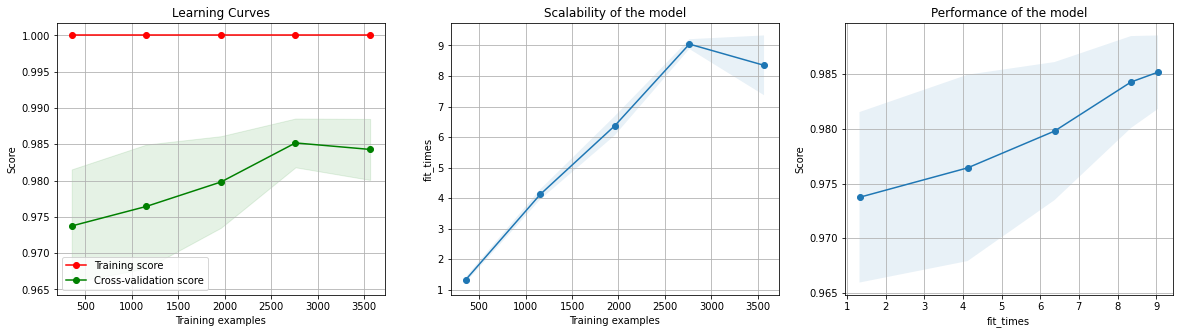

In [61]:
# Plotting Learning Curve
plot_learning_curve(best_estimator_pipeline_full_round1, 'Learning Curves',
                    x_train_full_final, y_train_full, n_jobs=-1)

###Cross Validation and Train scores

In [62]:
# Cross Validation score & Train score
print('Train score on complete dataset: ', round(best_estimator_pipeline_full_round1.score(x_train_full_final, y_train_full), 4))

print('Cross Validation score on complete dataset: ', round(complete_grid_pipeline_full_round1.best_score_, 4))

Train score on complete dataset:  1.0
Cross Validation score on complete dataset:  0.9847


###Evaluating model on test set

In [63]:
# Final Pipeline

def final_pipeline_full(text):
    # X_test_cleaned = cp.SpacyPreprocessor(model='en_core_web_sm').transform(text)
    cleaned_text_full = joblib.load(file_x_test_full_cleaned_sparse_embed)
    x_features_full, feature_names_full = featurizer.fit_transform(text)
    x_final_full = pd.concat((pd.DataFrame(cleaned_text_full, columns=['cleaned_text']),
                         pd.DataFrame(x_features_full, columns=feature_names_full)), axis=1)
    best_estimator_pipeline_full_round1 = joblib.load(file_best_estimator_pipeline_full_round1)
    predictions = best_estimator_pipeline_full_round1.predict(x_final_full)
    return predictions
y_test_pred_full = final_pipeline_full(x_test_full)
print('\nTest set classification report on complete dataset :\n\n', classification_report(y_test_full, y_test_pred_full ))


Test set classification report on complete dataset :

               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.94      0.91      0.93       149

    accuracy                           0.98      1115
   macro avg       0.97      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



# **Required Submissions:**
1.  Submit two colab/jupyter notebooks
- (analysis with smaller subset and all three pipelines)
- (analysis with bigger subset and only final pipeline)
2. Pdf version of the notebooks (HWs will not be graded if pdf version is not provided.
3. **The notebooks and pdf files should have the output.**
4. **Name files as follows : FirstName_file1_hw2, FirstName_file2_h2**

In [1]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 javascript-common libapache-pom-java
  libcommons-logging-java libcommons-parent-java libfontbox-java libgs9
  libgs9-common libidn11 libijs-0.35 libjbig2dec0 libjs-jquery libkpathsea6
  libpdfbox-java libptexenc1 libruby2.7 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libzzip-0-13 lmodern poppler-data preview-latex-style rake
  ruby ruby-minitest ruby-net-telnet ruby-power-assert ruby-test-unit
  ruby-xmlrpc ruby2.7 rubygems-integration t1utils teckit tex-common tex-gyre
  texlive-base texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf apache2 | lighttpd
  | httpd libavalo

In [3]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/JyotsnaNagaprasad_Ambekar_HW3.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/JyotsnaNagaprasad_Ambekar_HW3.ipynb to pdf
[NbConvertApp] Support files will be in JyotsnaNagaprasad_Ambekar_HW3_files/
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW3_files
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW3_files
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW3_files
[NbConvertApp] Making directory ./JyotsnaNagaprasad_Ambekar_HW3_files
[NbConvertApp] Writing 149627 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 298810 bytes to /content/drive/MyDrive/NLP_UTD/Assignments/Assignment_3/JyotsnaNagaprasad_Ambekar_HW3.pdf
